In [21]:
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Ian.Gottschalk\Miniconda3\envs\simpegEM1D-environment\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['floor', 'time', 'inv', 'std', 'beta', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [23]:
from simpegEM1D import skytem_HM_2015
time = np.logspace(-5, -2, 31)
hz = get_vertical_discretization_time(time, facter_tmax=0.3, factor_tmin=10., n_layer=19)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'stepoff',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time,
    base_frequency = 25.,
    use_lowpass_filter=False,
    high_cut_frequency=210*1e3        
)
sig_half = 1./20.
sig_blk = sig_half * 20.
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

In [24]:
# two_layer_map = TwoLayerMap(mesh, logSigma=True)


In [28]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (-30>LocSigZ) & (-70<LocSigZ)
sig[blk_ind] = sig_blk
# sig[blk_ind] = sig_half
m_true = np.log(sig)

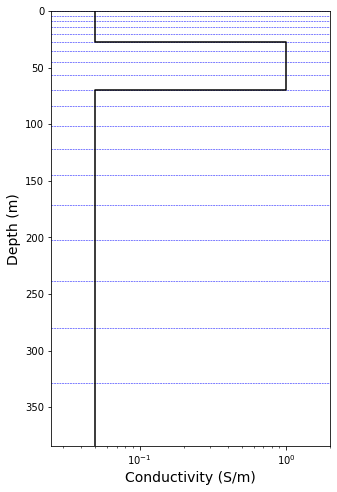

In [35]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=True)
ax.invert_yaxis()

In [36]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)

Wall time: 56 ms


In [37]:
J = prob.getJ_sigma(m_true)

C:\Users\Ian.Gottschalk\Miniconda3\envs\simpegEM1D-environment\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.


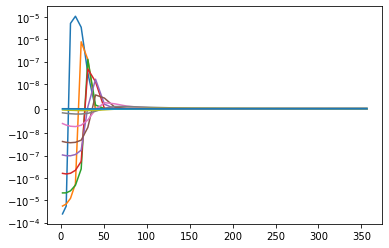

In [38]:
i_time=10
for i_time in range(0, time.size, 3):
    plt.plot(mesh1D.vectorCCx, J[i_time,:])
plt.yscale('symlog', linthreshy=1e-8)

In [39]:
TDsurvey.frequency.shape

(116,)

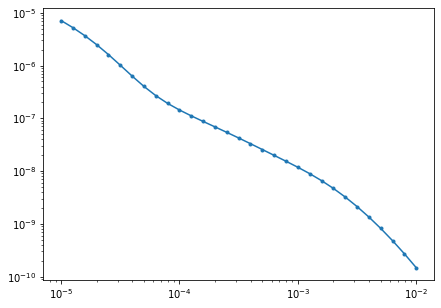

In [40]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, '.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [41]:
np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.05
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.07
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor

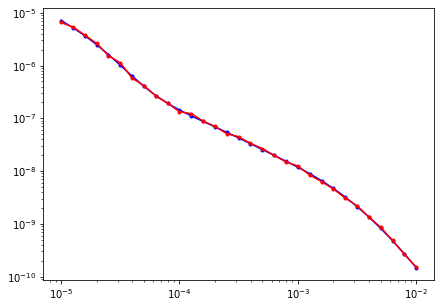

In [42]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, 'b.-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [43]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
uncert = (abs(TDsurvey.dobs)*std+floor)
dmisfit.W = 1./ uncert

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [44]:
m0 = np.log(np.ones_like(sig)*sig_half)
d_0 = TDsurvey.dpred(m0)
# delta = prob.get_threshold(uncert)

In [45]:
reg = Regularization.Sparse(
    mesh1D,
    mapping=Maps.IdentityMap(mesh1D),
    alpha_s=1.,
    alpha_x=1.
)
p = 0
qx, qz = 2., 2.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, betaSearch=False,
    chifact_start = 1.
)
opt = Optimization.ProjectedGNCG(maxIter = 25)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
# update_sense = Directives.UpdateSensitivityWeights(threshold=delta)
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [46]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.84e+00  1.53e+03  0.00e+00  1.53e+03    5.28e+02      0              
   1  1.92e+00  9.59e+02  2.83e+01  1.01e+03    1.77e+02      0              
   2  9.61e-01  2.87e+02  1.23e+02  4.06e+02    2.53e+02      0              
   3  4.80e-01  3.78e+01  1.83e+02  1.26e+02    1.29e+02      0              
   4  2.40e-01  1.98e+01  1.82e+02  6.36e+01    9.28e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.5265e+02
1 : |xc-x_last| = 5.1357e-01 

In [47]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  ProjectedGNCG.activeSet                 :        5
  ProjectedGNCG.doEndIteration            :        5
  ProjectedGNCG.doStartIteration          :        5
  ProjectedGNCG.projection                :       23
  ProjectedGNCG.scaleSearchDirection      :        5

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 9.56e-05, 2.96e-03,   31x
  EM1D.Jvec_approx                        : 7.71e-03, 2.39e-01,   31x
  ProjectedGNCG.findSearchDirection       : 2.02e-02, 1.01e-01,    5x
  ProjectedGNCG.minimize                  : 1.73e+00, 1.73e+00,    1x
  ProjectedGNCG.modifySearchDirection     : 8.72e-02, 4.36e-01,    5x


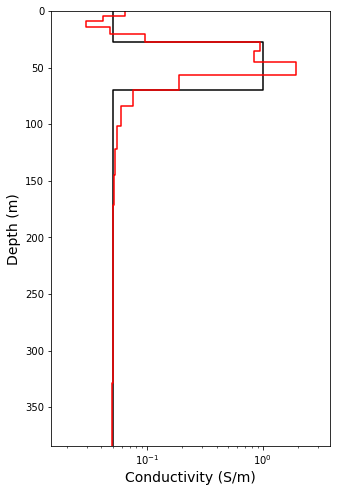

In [49]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D)
Utils1D.plotLayer(expmap*mopt, mesh1D, showlayers=False, **{'color':'r'})
# Utils1D.plotLayer(expmap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1.})
ax.invert_yaxis()


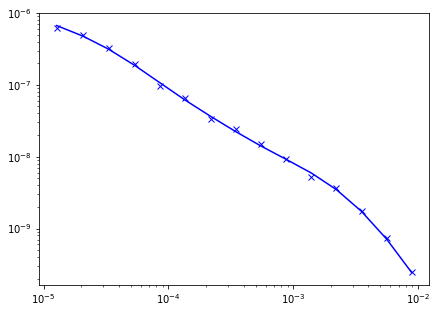

In [19]:
fig, axes = plt.subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');

In [1]:
import pyMKL